In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import noisereduce as nr
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import jiwer  
import time

import pywt 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Dropout, Masking
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

c:\Users\gabry\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Preparation

## Loading Data

In [2]:
# Konfigurasi
DATASET_PATH = "dataset"
COMMANDS = ["baca", "berhenti", "foto", "halo", "info", "kembali", "ulang"]

In [3]:
# Load data
X = []
y = []

for label in COMMANDS:
    folder_path = os.path.join(DATASET_PATH, label)
    for filename in os.listdir(folder_path):
        if filename.endswith(".wav"):
            file_path = os.path.join(folder_path, filename)
            X.append(file_path)
            y.append(label)

X = np.array(X)  
y = np.array(y)

In [4]:
len(X)

2541

In [5]:
# Buat dataframe
df = pd.DataFrame()
df['speech'] = X 
df['label'] = y

df.head()

,speech,label
0,dataset\baca\baca1.wav,baca
1,dataset\baca\baca10.wav,baca
2,dataset\baca\baca100.wav,baca
3,dataset\baca\baca101.wav,baca
4,dataset\baca\baca102.wav,baca


In [6]:

df['label'].value_counts()

label
kembali     368
foto        364
baca        363
berhenti    363
ulang       363
info        361
halo        359
Name: count, dtype: int64

In [7]:
# Tahapan Preprocessing

def load_audio(file_path, sr=16000):
    audio, sample_rate = librosa.load(file_path, sr=sr)
    return audio / np.max(np.abs(audio)), sample_rate 

In [8]:
# Dapatkan jumlah core
num_cores = multiprocessing.cpu_count()

# Jalankan preprocessing
results = Parallel(n_jobs=num_cores)(
    delayed(load_audio)(file_path)
    for file_path in df['speech']
)

df.head()


,speech,label
0,dataset\baca\baca1.wav,baca
1,dataset\baca\baca10.wav,baca
2,dataset\baca\baca100.wav,baca
3,dataset\baca\baca101.wav,baca
4,dataset\baca\baca102.wav,baca


## EDA

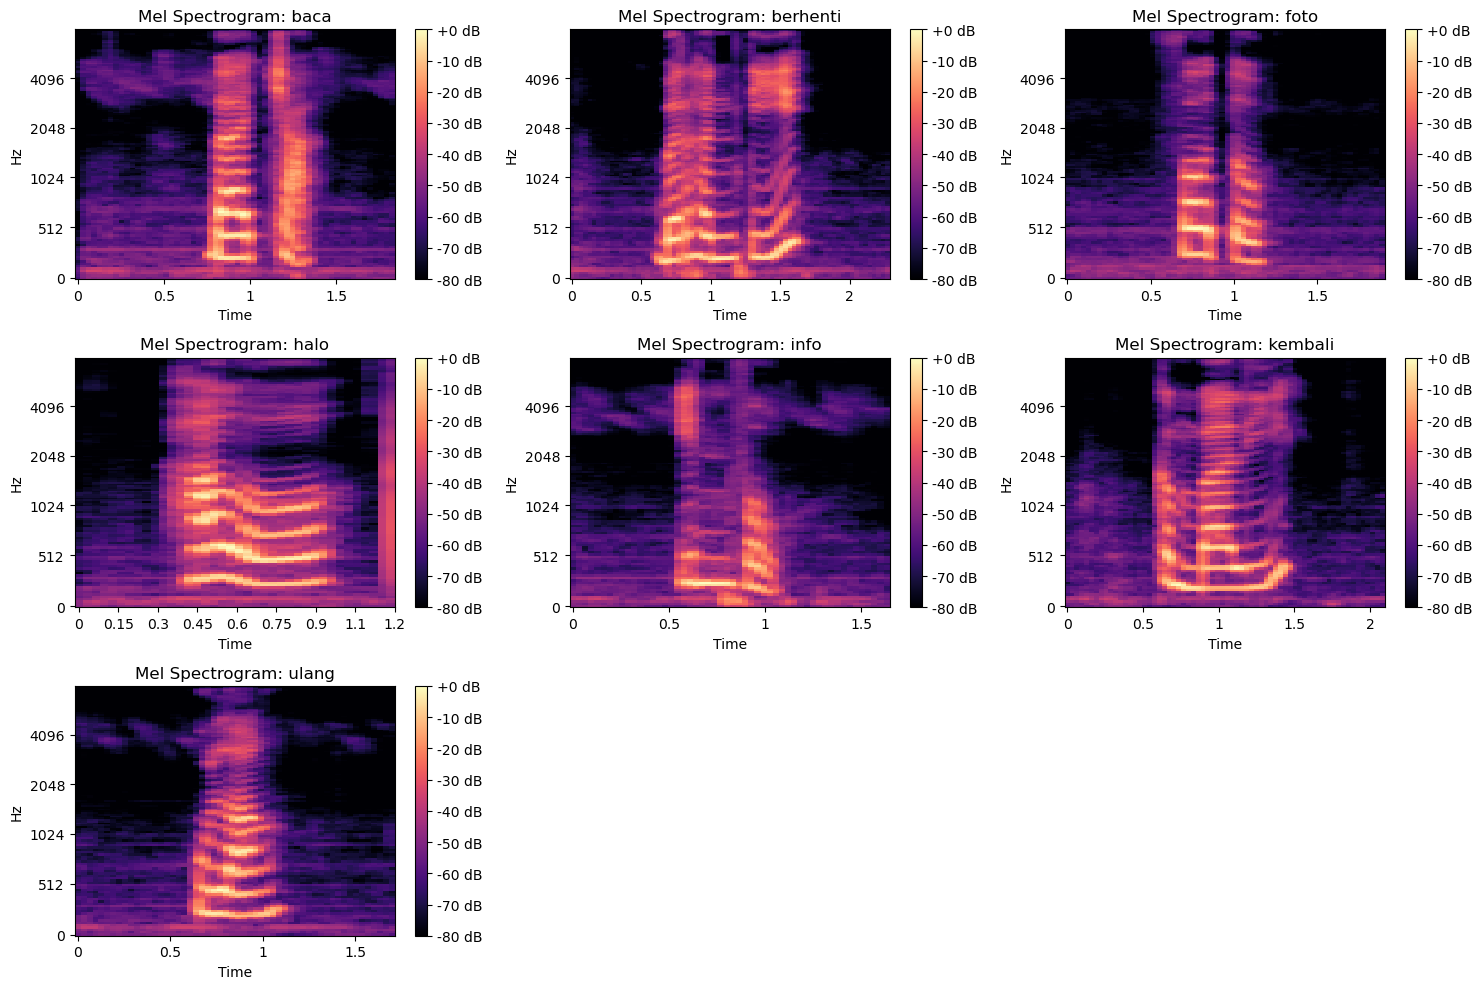

In [9]:
# Visualisasi spectrogram per label
def visualize_per_label(df):
    labels = df['label'].unique()

    plt.figure(figsize=(15, 10))

    for i, label in enumerate(labels):
        example_path = df[df['label'] == label]['speech'].values[0]

        # Preprocessing
        audio, sr = load_audio(example_path)

        # Menghitung Mel Spectrogram
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)

        # Plot
        plt.subplot(3, 3, i + 1)
        librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max),
                                 sr=sr, x_axis='time', y_axis='mel')
        plt.title(f'Mel Spectrogram: {label}')
        plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

# Panggil fungsi visualisasi
visualize_per_label(df)

## Data Augmentation

In [10]:
# Inisialisasi list untuk menyimpan hasil split
train_data = []
valid_data = []

# Lakukan split 60:40 untuk setiap label
for label in COMMANDS:
    df_label = df[df['label'] == label]
    df_train, df_valid = train_test_split(
        df_label, 
        test_size=0.4, 
        random_state=42, 
        shuffle=True
    )
    train_data.append(df_train)
    valid_data.append(df_valid)

# Gabungkan kembali semua label
df_train = pd.concat(train_data).reset_index(drop=True)
df_valid = pd.concat(valid_data).reset_index(drop=True)

# Cek distribusi data
print("Distribusi data training:")
print(df_train['label'].value_counts())
print("\nDistribusi data validasi:")
print(df_valid['label'].value_counts())


Distribusi data training:
label
kembali     220
foto        218
baca        217
berhenti    217
ulang       217
info        216
halo        215
Name: count, dtype: int64

Distribusi data validasi:
label
kembali     148
baca        146
berhenti    146
foto        146
ulang       146
info        145
halo        144
Name: count, dtype: int64


In [11]:
def noise(data):
    noise_amp = 0.05 * np.random.uniform() * np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data

def shift(data):
    s_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, s_range) 

def stretch(data, rate=0.7):
    return librosa.effects.time_stretch(data, rate=rate)

def pitch(data, sample_rate):
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change = pitch_pm * 2 
    data = librosa.effects.pitch_shift(y=data.astype('float64'), 
                                       sr=sample_rate, 
                                       n_steps=pitch_change, 
                                       bins_per_octave=bins_per_octave)
    return data

def dyn_change(data):
    dyn = np.random.uniform(low=0.3, high=2.0)
    return data * dyn

def speedNpitch(data):
    length_change = np.random.uniform(low=0.8, high=1)
    speed_fac = 1.2 / length_change
    tmp = np.interp(np.arange(0, len(data), speed_fac), np.arange(0, len(data)), data)
    minlen = min(len(data), len(tmp))
    data = np.zeros_like(data)
    data[0:minlen] = tmp[0:minlen]
    return data

In [12]:
# Siapkan list untuk data dan label hasil augmentasi
augmented_speech = []
augmented_label = []

# Proses augmentasi per data training
for idx, row in df_train.iterrows():
    file_path = row['speech']
    label = row['label']
    
    # Load audio
    audio, sr = load_audio(file_path)
    
    # Data original
    augmented_speech.append(audio)
    augmented_label.append(label)
    
    # Data augmented
    augmented_speech.append(noise(audio))
    augmented_label.append(label)
    
    augmented_speech.append(shift(audio))
    augmented_label.append(label)
    
    try:
        augmented_speech.append(stretch(audio))
        augmented_label.append(label)
    except Exception as e:
        print(f"Stretch failed for {file_path}: {e}")
    
    try:
        augmented_speech.append(pitch(audio, sr))
        augmented_label.append(label)
    except Exception as e:
        print(f"Pitch failed for {file_path}: {e}")
    
    augmented_speech.append(dyn_change(audio))
    augmented_label.append(label)
    
    augmented_speech.append(speedNpitch(audio))
    augmented_label.append(label)

# Buat DataFrame hasil augmentasi
df_augmented = pd.DataFrame({
    'speech': augmented_speech,
    'label': augmented_label
})

print(f"Total data setelah augmentasi: {len(df_augmented)}")
print(df_augmented['label'].value_counts())

Total data setelah augmentasi: 10640
label
kembali     1540
foto        1526
baca        1519
berhenti    1519
ulang       1519
info        1512
halo        1505
Name: count, dtype: int64


In [13]:
# Konversi ke array
X_train = np.array(df_augmented['speech'].tolist(), dtype=object)
y_train = np.array(df_augmented['label'].tolist())

X_valid = []

# Load ulang file audio validasi agar format sama (bukan path, tapi array audio)
for file_path in df_valid['speech']:
    audio, _ = load_audio(file_path)
    X_valid.append(audio)

X_valid = np.array(X_valid, dtype=object)
y_valid = np.array(df_valid['label'].tolist())

# Simpan ke file npz
np.savez("processed_speech_dataset.npz", 
         X_train=X_train, y_train=y_train,
         X_valid=X_valid, y_valid=y_valid)

print("Dataset berhasil disimpan")

Dataset berhasil disimpan


## MFCC

In [14]:
# Parameter MFCC
SAMPLE_RATE = 16000
N_MFCC = 13
N_MELS = 22

# Window 5ms–10ms: antara 80–160 samples
WINDOW_LENGTH = int(SAMPLE_RATE * 0.01)  # 10ms = 160 samples
HOP_LENGTH = int(SAMPLE_RATE * 0.005)    # 5ms hop = 80 samples

def wavelet_packet_decompose(signal, wavelet='db4', maxlevel=3):
    wp = pywt.WaveletPacket(data=signal, wavelet=wavelet, mode='symmetric', maxlevel=maxlevel)
    nodes = wp.get_level(maxlevel, order='freq')
    features = np.concatenate([n.data for n in nodes])
    return features

def extract_mfcc(signal, sample_rate):
    # Lakukan WPD terlebih dahulu
    signal_wpd = wavelet_packet_decompose(signal)
    
    # Ekstrak MFCC dari hasil WPD
    mfccs = librosa.feature.mfcc(
        y=signal_wpd, 
        sr=sample_rate, 
        n_mfcc=N_MFCC,
        n_mels=N_MELS,
        n_fft=WINDOW_LENGTH,
        hop_length=HOP_LENGTH
    )
    return mfccs.T  # (waktu, fitur)

# def extract_mfcc(audio, sample_rate, n_mfcc=13):
#     """Extract MFCC features from audio"""
#     mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
#     return mfcc.T  # shape: (time_steps, n_mfcc)

# def full_mfcc_pipeline(file_path):
#     """Full processing pipeline for a single audio file"""
#     audio, sr = load_audio(file_path)
#     return extract_mfcc(audio, sr)

# def parallel_mfcc_extraction(file_paths, n_jobs=-1):
#     return Parallel(n_jobs=n_jobs)(
#         delayed(full_mfcc_pipeline)(file_path)
#         for file_path in tqdm(file_paths, desc="Extracting MFCC features")
#     )

In [15]:
X_train_mfcc = [extract_mfcc(audio, SAMPLE_RATE) for audio in X_train]
X_valid_mfcc = [extract_mfcc(audio, SAMPLE_RATE) for audio in X_valid]

# Modeling

In [16]:
# Padding agar semua memiliki dimensi yang sama
X_train_pad = pad_sequences(X_train_mfcc, padding='post', dtype='float32')
X_valid_pad = pad_sequences(X_valid_mfcc, padding='post', dtype='float32')

# Label encoding
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_valid_enc = le.transform(y_valid)

# Print encoding
for label, encoded in zip(le.classes_, range(len(le.classes_))):
    print(f"'{label}' -> {encoded}")


'baca' -> 0
'berhenti' -> 1
'foto' -> 2
'halo' -> 3
'info' -> 4
'kembali' -> 5
'ulang' -> 6


In [17]:
X_train_pad.shape

(10640, 930, 13)

In [18]:
# One-hot encoding
num_classes = len(le.classes_)
y_train_cat = to_categorical(y_train_enc, num_classes)
y_valid_cat = to_categorical(y_valid_enc, num_classes)

In [19]:
# Modeling

model = Sequential([
    Masking(mask_value=0.0, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, return_sequences=True),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dropout(0.2),
    
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


IndexError: tuple index out of range

In [ ]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
# Training
history = model.fit(
    X_train_pad, y_train_cat,
    validation_data=(X_valid_pad, y_valid_cat),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)

# Val accuracy terbaik
best_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1  
print(f"Val accuracy terbaik: {best_val_acc:.4f} pada epoch ke-{best_epoch}")

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.axvline(best_epoch-1, color='r', linestyle='--', label='Best Epoch')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.axvline(best_epoch-1, color='r', linestyle='--', label='Best Epoch')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# # Evaluasi

# # Predict
# start = time.time()
# y_pred_probs = model.predict(X_val)
# end = time.time()

# y_pred = np.argmax(y_pred_probs, axis=1)
# y_true = np.argmax(y_val_cat, axis=1)

# # WER
# ref = [le.classes_[i] for i in y_true]
# hyp = [le.classes_[i] for i in y_pred]
# wer = jiwer.wer(ref, hyp)

# # RTF
# audio_duration_total = (X_val.shape[0] * X_val.shape[1]) / 16000  # asumsi 16kHz
# rtf = (end - start) / audio_duration_total

# # Precision, Recall, F1 Score
# precision = precision_score(y_true, y_pred, average='weighted')
# recall = recall_score(y_true, y_pred, average='weighted')
# f1 = f1_score(y_true, y_pred, average='weighted')

# # Classification report
# report = classification_report(y_true, y_pred, target_names=le.classes_)
# print("=== Classification Report ===")
# print(report)
# print(f"Word Error Rate (WER): {wer:.4f}")
# print(f"Real Time Factor (RTF): {rtf:.4f}")
# print(f"Precision (weighted): {precision:.4f}")
# print(f"Recall (weighted): {recall:.4f}")
# print(f"F1 Score (weighted): {f1:.4f}")